# Attention vectors

The attention vector $\alpha_t$ at time $t$ is computed by from the previous attention vectors, the prediction of the current decoder state and the corresponding annotation sequences (output of the encoder). Equations (17) - (20) in the paper.

The low resolution annotation sequence $A = \{a_1, \dots, a_L\}$  are essentially flattened features with $L = H \times W$ number of *C*-dimensional annotations.

A convolutional function $Q$ is applied to sum of the previous attention vectors $F = Q * \sum_{l = 1}^{t - 1} {\alpha_l}$. The energy $e_{ti}$ at time $t$ for the $i$-th annotation is computed as $e_{ti} = \nu_{att}^{T} \tanh(U_s \hat{s}_t + U_a a_i + U_f f_i)$ where $\nu_{att}$, $U_s$, $U_a$ and $U_f$ are learned weights.

The attention vector $\alpha_t$ is the softmax of the energy $e_t$, that is: $\alpha_{ti} = \frac{exp(e_{ti})}{\sum_{k = 1}^{L} exp(e_{tk})}$.

Finally, the coverage vector is the sum of the weighted annotations: $cA_t = \sum_{i = 1}^{L} \alpha_{ti} a_i$

The same is done for the high resolution, by using $B = \{b_1, \dots, b_{4L}\}$ instead of $A = \{a_1, \dots, a_L\}$ and separate weights. The only shared weight between them is $U_s$.

The initial attention vector $\alpha_0$ is initialised to zero.

In [1]:
# To make it possible to import the code
import sys
sys.path.append("..")

In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.transform
import torch
import torchvision.transforms as transforms
import evaluate
from IPython.display import display
from torch.utils.data import DataLoader
from checkpoint import load_checkpoint
from model import Encoder, Decoder
from dataset import CrohmeDataset, START, PAD, collate_batch
%matplotlib inline

In [3]:
# Set a higher limit for printing tensor values before they are truncated for readability.
torch.set_printoptions(threshold=1e6)

In [4]:
batch_size = 1
use_cuda = False and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [5]:
dataset = CrohmeDataset(
    os.path.join("..", evaluate.test_sets["2016"]["groundtruth"]),
    os.path.join("..", evaluate.tokensfile),
    root=os.path.join("..", evaluate.test_sets["2016"]["root"]),
    transform=evaluate.transformers)
data_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_batch,
)

In [6]:
data_iter = iter(data_loader)
batch = next(data_iter)

input = batch["image"].to(device)
expected = batch["truth"]["encoded"].to(device)
expected[expected == -1] = dataset.token_to_id[PAD]
expected_decoded = [[dataset.id_to_token[tok.item()] for tok in exp] for exp in expected]
max_len = expected.size(1)

In [7]:
checkpoint = load_checkpoint("../checkpoints/xavier-dropout-bottleneckonly-teacher0.5-0407.pth", cuda=use_cuda)

In [8]:
enc = Encoder(img_channels=3, checkpoint=checkpoint["model"]["encoder"]).to(device)
dec = Decoder(
    len(dataset.id_to_token),
    evaluate.low_res_shape,
    evaluate.high_res_shape,
    checkpoint=checkpoint["model"]["decoder"],
    device=device,
).to(device)
enc.eval()
dec.eval()

enc_low_res, enc_high_res = enc(input)
dec.reset(batch_size)
hidden = dec.init_hidden(batch_size).to(device)
# Starts with a START token
sequence = torch.full(
    (batch_size, 1),
    dataset.token_to_id[START],
    dtype=torch.long,
    device=device,
)
for i in range(max_len - 1):
    previous = sequence[:, -1].view(-1, 1)
    out, hidden = dec(previous, hidden, enc_low_res, enc_high_res)
    _, top1_id = torch.topk(out, 1)
    sequence = torch.cat((sequence, top1_id), dim=1)

preds_decoded = [[dataset.id_to_token[tok.item()] for tok in seq] for seq in sequence]

The attention vectors are available in the `coverage_attn_*` of the decoder. `alpha[t]` is the attention vector at time $t$. So are the weights, except for $U_s$, which has been lifted to the decoder, because it is shared (available as `dec.U_pred`).

In [9]:
# Attention vectors of first batch
attn_low = dec.coverage_attn_low.alpha[0]
attn_high = dec.coverage_attn_high.alpha[0]

# Image of first batch
img = input[0]

# Predictions of first batch
preds_batch = preds_decoded[0]

In [10]:
to_pil_image = transforms.ToPILImage()

def show_attention_images(img, preds, attn, attn_h, attn_w, smooth=False):
    pil_img = to_pil_image(img)
    _, h, w = img.size()
    # , figsize=(3.5*num_axes, 3*timesteps)

    for pred, a in zip(preds, attn):
        fig, ax = plt.subplots(1, 1)
        # Resize attentions from flat to 2D (L = H x W)
        a_2d = a.view(attn_h, attn_w)
        a_2d = a_2d.detach().cpu().numpy()
        upscale_factor = max(h // attn_h, w // attn_w)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(pil_img)
        attn_mask = (
            skimage.transform.pyramid_expand(
                a_2d, upscale=upscale_factor, multichannel=False)
            if smooth
            else skimage.transform.resize(a_2d, (h, w), mode="reflect", anti_aliasing=True)
        )
        attn_img = ax.imshow(attn_mask, alpha=0.7)
        attn_img.set_cmap(cm.Greys_r)
        ax.text(1.03, 0.5, "{:>5}".format(pred), transform=ax.transAxes, fontsize=15)
        
        print(a)
        display(fig)
        plt.close()

In [11]:
expected_decoded[0]

['<SOS>',
 '\\left',
 '\\{',
 'x',
 ',',
 'y',
 '\\right',
 '\\}',
 '=',
 'x',
 '\\times',
 'y',
 '+',
 'y',
 '\\times',
 'x',
 '<EOS>']

## Low resolution attention

In [12]:
attn_low

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0002, 0.0001,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0692, 0.6936, 0.0171,
         0.0007, 0.0004, 0.0005, 0.0001, 0.0000, 0.0033, 0.1795, 0.0262, 0.0022,
         0.0045, 0.0014, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


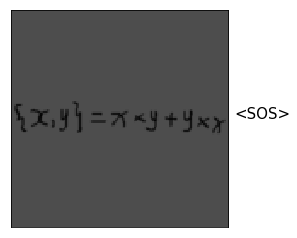

tensor([1.4942e-05, 3.0390e-05, 1.8536e-05, 1.2533e-05, 7.8188e-06, 8.4877e-06,
        9.4689e-06, 2.8399e-06, 4.9012e-06, 1.1357e-06, 2.0143e-06, 2.1786e-06,
        1.3184e-06, 1.5012e-06, 1.1548e-06, 2.8306e-07, 1.8583e-04, 1.0411e-04,
        2.7244e-05, 1.5662e-05, 1.2633e-05, 4.0157e-05, 1.8870e-05, 1.4666e-06,
        6.9221e-02, 6.9361e-01, 1.7081e-02, 6.9124e-04, 4.2971e-04, 5.4294e-04,
        6.8984e-05, 1.0194e-06, 3.3061e-03, 1.7952e-01, 2.6224e-02, 2.1636e-03,
        4.5403e-03, 1.3766e-03, 4.5813e-05, 1.1444e-05, 7.8217e-06, 2.5682e-05,
        2.7925e-06, 6.0940e-07, 9.9090e-07, 1.7862e-06, 2.6422e-06, 4.0092e-07,
        1.6707e-05, 1.9274e-05, 1.2201e-05, 1.3957e-05, 1.0202e-05, 6.6884e-06,
        6.7625e-06, 5.7116e-07, 6.0800e-05, 1.8553e-04, 1.1769e-04, 6.5995e-05,
        3.7461e-05, 2.5508e-05, 1.5071e-05, 2.6806e-06])


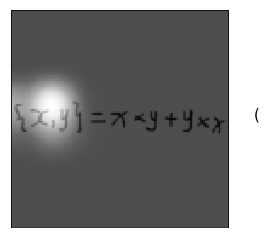

tensor([7.9945e-06, 1.7773e-05, 1.1702e-05, 7.8609e-06, 5.8878e-06, 6.3434e-06,
        5.6632e-06, 1.9861e-06, 1.8530e-06, 2.8482e-07, 7.9206e-07, 1.1410e-06,
        7.4957e-07, 9.4237e-07, 6.3043e-07, 1.5091e-07, 3.5763e-05, 2.6428e-05,
        1.7058e-05, 1.5940e-05, 1.1892e-05, 3.7918e-05, 1.3273e-05, 9.3821e-07,
        2.2713e-02, 7.2244e-01, 2.4976e-02, 9.3795e-04, 4.2577e-04, 7.0151e-04,
        9.4461e-05, 7.7582e-07, 3.1336e-03, 1.9827e-01, 2.0030e-02, 1.9927e-03,
        3.0152e-03, 6.6783e-04, 2.0496e-05, 4.0866e-06, 3.0312e-06, 2.1054e-05,
        2.6639e-06, 4.2853e-07, 5.3792e-07, 1.1216e-06, 1.4461e-06, 1.7246e-07,
        7.6627e-06, 9.5391e-06, 6.4537e-06, 8.9309e-06, 6.3191e-06, 4.3166e-06,
        4.0919e-06, 3.2506e-07, 2.9467e-05, 9.7334e-05, 5.8171e-05, 3.4452e-05,
        1.9288e-05, 1.5164e-05, 7.2378e-06, 1.7406e-06])


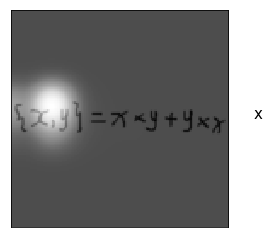

tensor([2.8009e-06, 5.9838e-06, 4.8345e-06, 3.1496e-06, 2.8632e-06, 2.9577e-06,
        2.1581e-06, 9.4415e-07, 1.0589e-06, 2.1513e-07, 5.6168e-07, 7.8548e-07,
        5.0834e-07, 5.8764e-07, 3.8175e-07, 8.8606e-08, 7.5697e-06, 1.6736e-05,
        9.3435e-06, 8.5560e-06, 5.4536e-06, 1.7434e-05, 9.8116e-06, 6.1883e-07,
        8.4765e-03, 6.2582e-01, 1.2129e-02, 2.6549e-04, 4.3368e-04, 9.3740e-04,
        1.1370e-04, 9.1918e-07, 2.4492e-03, 3.3727e-01, 7.7818e-03, 5.0589e-04,
        3.0748e-03, 4.3436e-04, 1.5870e-05, 7.4416e-06, 2.8049e-06, 2.2622e-05,
        3.1564e-06, 5.4238e-07, 6.5922e-07, 1.0169e-06, 9.4748e-07, 1.0434e-07,
        4.5111e-06, 7.5326e-06, 5.1001e-06, 7.7745e-06, 4.6095e-06, 2.4028e-06,
        2.1257e-06, 1.7588e-07, 9.8905e-06, 3.8558e-05, 2.2983e-05, 1.5893e-05,
        8.7749e-06, 7.7115e-06, 3.3820e-06, 9.3354e-07])


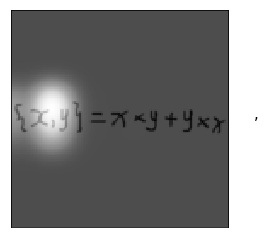

tensor([2.9016e-06, 9.0660e-06, 7.2128e-06, 4.1035e-06, 4.7327e-06, 6.0285e-06,
        3.7690e-06, 1.3611e-06, 4.6044e-07, 4.3267e-08, 1.8722e-07, 4.0203e-07,
        3.5804e-07, 4.8261e-07, 2.6874e-07, 4.8688e-08, 2.8760e-06, 6.3150e-06,
        8.3322e-06, 1.3676e-05, 1.3103e-05, 4.8948e-05, 1.9433e-05, 4.8493e-07,
        1.1109e-03, 6.6381e-02, 1.1769e-01, 1.6700e-03, 2.7335e-03, 5.0538e-03,
        5.4359e-04, 9.6718e-07, 3.2300e-04, 6.9560e-01, 8.1524e-02, 4.4069e-03,
        1.8022e-02, 4.4028e-03, 9.7404e-05, 1.5623e-05, 1.0154e-06, 1.6597e-05,
        2.7506e-06, 4.6087e-07, 4.8644e-07, 8.2786e-07, 9.2184e-07, 6.6312e-08,
        3.2266e-06, 6.6681e-06, 6.6037e-06, 1.1239e-05, 6.0795e-06, 2.7689e-06,
        2.8749e-06, 1.6220e-07, 1.0745e-05, 7.2105e-05, 5.2684e-05, 3.1821e-05,
        1.4335e-05, 1.4106e-05, 5.7848e-06, 1.4538e-06])


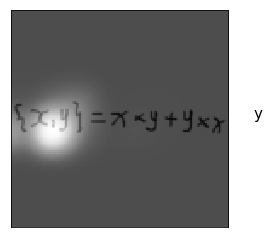

tensor([1.3031e-06, 3.7633e-06, 2.9211e-06, 1.7627e-06, 2.0275e-06, 2.3503e-06,
        1.4330e-06, 5.7849e-07, 3.8924e-07, 5.3319e-08, 2.0575e-07, 3.4187e-07,
        3.5743e-07, 4.4923e-07, 1.8976e-07, 4.3983e-08, 1.9837e-06, 6.5788e-06,
        7.1310e-06, 1.1783e-05, 9.1917e-06, 3.2988e-05, 1.2230e-05, 3.9416e-07,
        1.2340e-03, 2.3007e-01, 9.2655e-02, 1.5043e-03, 2.3328e-03, 4.2284e-03,
        4.5466e-04, 9.4404e-07, 5.7871e-04, 6.0396e-01, 5.1906e-02, 1.5997e-03,
        8.0169e-03, 1.1499e-03, 3.2866e-05, 5.8367e-06, 1.1184e-06, 4.5377e-05,
        6.6316e-06, 1.1249e-06, 1.0492e-06, 1.4293e-06, 8.8734e-07, 5.6382e-08,
        2.5740e-06, 8.2547e-06, 7.0209e-06, 1.2597e-05, 5.9899e-06, 2.2150e-06,
        1.5245e-06, 1.1027e-07, 4.7054e-06, 2.4420e-05, 1.7552e-05, 1.3058e-05,
        5.7722e-06, 4.9430e-06, 1.8088e-06, 5.3669e-07])


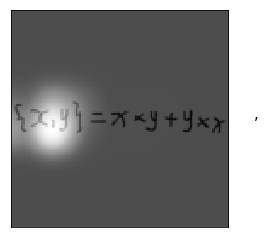

tensor([3.4409e-06, 1.2031e-05, 8.8860e-06, 5.2652e-06, 6.5962e-06, 1.0632e-05,
        6.8788e-06, 2.0500e-06, 4.9074e-07, 4.2597e-08, 2.1890e-07, 4.5294e-07,
        6.9215e-07, 1.0109e-06, 3.7019e-07, 7.4811e-08, 1.8565e-06, 4.5517e-06,
        1.2408e-05, 3.3372e-05, 3.8564e-05, 1.4970e-04, 5.4691e-05, 9.5040e-07,
        1.6555e-04, 1.4362e-02, 1.6410e-01, 9.6615e-03, 1.7596e-02, 2.8840e-02,
        3.4876e-03, 2.2917e-06, 8.1258e-05, 3.2474e-01, 2.5412e-01, 3.4060e-02,
        1.2381e-01, 2.3505e-02, 5.0980e-04, 3.0273e-05, 8.9523e-07, 4.9604e-05,
        1.4419e-05, 3.2834e-06, 3.0344e-06, 4.1738e-06, 3.6247e-06, 1.1319e-07,
        4.2370e-06, 1.6248e-05, 2.3444e-05, 4.4633e-05, 2.0078e-05, 6.8111e-06,
        5.0906e-06, 2.6625e-07, 1.4070e-05, 1.2181e-04, 1.1103e-04, 7.4015e-05,
        2.6176e-05, 2.1161e-05, 8.5969e-06, 2.1049e-06])


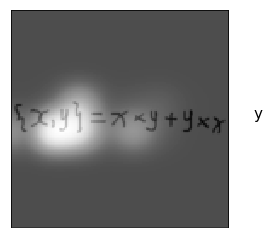

tensor([2.3087e-06, 7.0856e-06, 5.1154e-06, 2.9009e-06, 3.6043e-06, 4.9597e-06,
        3.1827e-06, 1.1607e-06, 5.4141e-07, 5.8273e-08, 2.7345e-07, 5.0477e-07,
        7.9235e-07, 1.1186e-06, 3.3617e-07, 8.0394e-08, 1.7547e-06, 5.3128e-06,
        1.2967e-05, 3.6475e-05, 3.1025e-05, 1.1276e-04, 3.9086e-05, 9.1793e-07,
        1.8401e-04, 4.1542e-02, 1.8978e-01, 1.0058e-02, 1.7893e-02, 2.8661e-02,
        3.0787e-03, 2.8364e-06, 1.2555e-04, 3.9602e-01, 2.1445e-01, 1.5913e-02,
        7.2513e-02, 8.7282e-03, 2.1087e-04, 1.7992e-05, 1.0354e-06, 1.2718e-04,
        4.1625e-05, 8.6598e-06, 8.3363e-06, 1.0055e-05, 4.8468e-06, 1.5725e-07,
        4.6427e-06, 2.3494e-05, 2.8226e-05, 5.6873e-05, 2.5746e-05, 7.1010e-06,
        3.6386e-06, 2.3618e-07, 9.2744e-06, 6.0908e-05, 5.0337e-05, 4.2324e-05,
        1.5897e-05, 1.1572e-05, 3.9744e-06, 1.1077e-06])


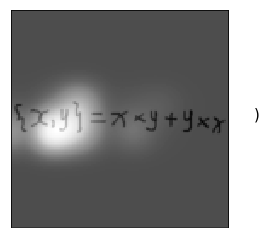

tensor([4.0448e-06, 1.3986e-05, 9.4726e-06, 5.5571e-06, 7.2777e-06, 1.0181e-05,
        6.3579e-06, 2.0825e-06, 8.2836e-07, 1.1508e-07, 5.1998e-07, 1.0705e-06,
        2.0972e-06, 2.7427e-06, 7.6874e-07, 1.7910e-07, 1.3662e-06, 4.0132e-06,
        1.6528e-05, 5.4728e-05, 4.3492e-05, 1.5294e-04, 7.6215e-05, 2.1509e-06,
        4.3239e-05, 9.7537e-03, 2.2394e-01, 2.4488e-02, 2.1638e-02, 3.9420e-02,
        7.4656e-03, 7.8093e-06, 3.0613e-05, 1.1539e-01, 3.5737e-01, 5.5880e-02,
        1.2742e-01, 1.4862e-02, 6.0540e-04, 2.9173e-05, 1.1568e-06, 2.2249e-04,
        1.2181e-04, 2.9805e-05, 3.9747e-05, 3.8999e-05, 1.7263e-05, 4.6171e-07,
        7.1467e-06, 4.6066e-05, 6.9023e-05, 1.4481e-04, 7.5815e-05, 1.8677e-05,
        8.3104e-06, 5.7143e-07, 1.5390e-05, 1.1388e-04, 1.0078e-04, 9.3318e-05,
        3.4249e-05, 2.2421e-05, 8.5793e-06, 2.2784e-06])


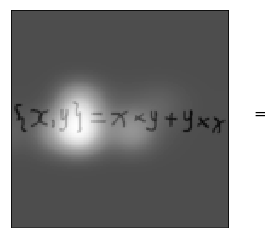

tensor([7.8293e-06, 1.9877e-05, 1.4125e-05, 9.7896e-06, 1.3901e-05, 3.1117e-05,
        2.6342e-05, 6.7172e-06, 1.2459e-06, 1.3095e-07, 5.5918e-07, 1.3487e-06,
        2.7323e-06, 6.3165e-06, 2.1338e-06, 4.7911e-07, 2.1440e-06, 3.5584e-06,
        2.2691e-05, 1.3513e-04, 2.5860e-04, 9.1843e-04, 3.3653e-04, 7.4519e-06,
        2.5947e-05, 8.8052e-04, 1.0362e-02, 2.7206e-02, 3.6949e-01, 1.8425e-01,
        1.6827e-02, 1.3941e-05, 8.2159e-06, 7.3468e-03, 1.1642e-02, 5.7247e-02,
        2.8443e-01, 2.5190e-02, 9.4621e-04, 3.2286e-05, 6.9304e-07, 5.2243e-05,
        4.0496e-05, 3.8676e-05, 4.0210e-05, 6.7638e-05, 7.3545e-05, 1.7924e-06,
        1.2340e-05, 6.3561e-05, 1.7990e-04, 4.1241e-04, 2.1320e-04, 7.4175e-05,
        4.3857e-05, 2.1141e-06, 3.1911e-05, 2.2432e-04, 2.8440e-04, 2.4092e-04,
        8.4921e-05, 5.7125e-05, 2.5077e-05, 6.7962e-06])


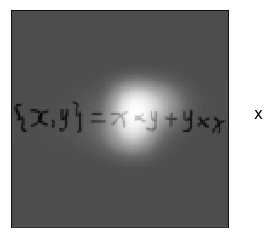

tensor([2.2319e-06, 5.8240e-06, 4.0020e-06, 2.1560e-06, 2.8411e-06, 4.7810e-06,
        3.5794e-06, 1.2709e-06, 3.5808e-07, 3.4657e-08, 1.5303e-07, 3.2203e-07,
        6.2493e-07, 1.2308e-06, 3.9158e-07, 9.8672e-08, 5.3019e-07, 9.1577e-07,
        3.7718e-06, 1.5983e-05, 2.7312e-05, 1.5077e-04, 7.9888e-05, 2.1677e-06,
        6.7821e-06, 6.7006e-04, 3.9849e-03, 3.1260e-03, 8.1137e-02, 1.6457e-01,
        1.3239e-02, 1.2892e-05, 6.1108e-06, 1.6825e-02, 1.3462e-02, 2.7329e-02,
        6.3245e-01, 4.0698e-02, 1.2332e-03, 6.2324e-05, 2.2802e-07, 3.3277e-05,
        3.6013e-05, 2.5835e-05, 5.6741e-05, 7.2907e-05, 4.0385e-05, 6.8587e-07,
        3.7064e-06, 2.2030e-05, 5.2595e-05, 1.2730e-04, 7.7855e-05, 1.9792e-05,
        9.2383e-06, 4.3231e-07, 9.3387e-06, 8.3973e-05, 7.4365e-05, 7.3064e-05,
        3.0983e-05, 1.8179e-05, 6.4804e-06, 1.4260e-06])


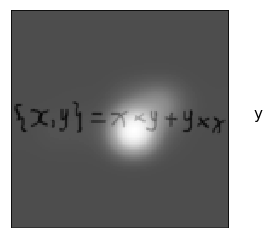

tensor([1.7307e-06, 5.4824e-06, 3.8620e-06, 1.9160e-06, 2.6676e-06, 4.1358e-06,
        2.8877e-06, 9.3309e-07, 3.0162e-07, 2.8957e-08, 1.1027e-07, 2.3503e-07,
        4.9641e-07, 1.0434e-06, 3.0473e-07, 8.9516e-08, 3.8516e-07, 7.2828e-07,
        2.8830e-06, 1.2120e-05, 1.8782e-05, 1.3851e-04, 8.7630e-05, 2.4364e-06,
        3.5302e-06, 2.9647e-04, 3.9017e-03, 1.8726e-03, 5.8389e-02, 2.0090e-01,
        3.1392e-02, 2.7810e-05, 2.5232e-06, 5.4557e-03, 8.0839e-03, 1.8473e-02,
        5.8583e-01, 8.1413e-02, 2.7403e-03, 1.1251e-04, 1.5114e-07, 1.9413e-05,
        1.7826e-05, 1.6886e-05, 6.4284e-05, 1.0077e-04, 5.4059e-05, 9.7626e-07,
        3.2804e-06, 1.6905e-05, 4.2065e-05, 1.1515e-04, 1.0340e-04, 3.0607e-05,
        1.3319e-05, 5.4152e-07, 5.7177e-06, 4.8684e-05, 5.1366e-05, 5.4630e-05,
        2.7292e-05, 1.8776e-05, 7.0938e-06, 1.3422e-06])


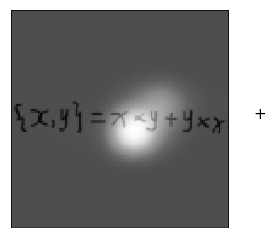

tensor([8.0752e-07, 2.6292e-06, 1.8596e-06, 8.7229e-07, 1.1224e-06, 2.1924e-06,
        1.8507e-06, 5.1446e-07, 1.1399e-07, 9.9106e-09, 3.9594e-08, 7.8116e-08,
        1.2728e-07, 3.7046e-07, 1.2266e-07, 4.2828e-08, 1.4845e-07, 2.3695e-07,
        7.5438e-07, 2.1454e-06, 5.6661e-06, 8.8475e-05, 7.1097e-05, 1.6437e-06,
        2.0065e-06, 1.0792e-04, 7.4363e-04, 3.1587e-04, 1.2758e-02, 8.0886e-02,
        3.9630e-02, 2.5942e-05, 9.7614e-07, 3.0107e-03, 4.3728e-03, 1.3660e-02,
        5.6957e-01, 2.6574e-01, 8.3513e-03, 2.0860e-04, 5.0439e-08, 4.0798e-06,
        3.5254e-06, 4.0041e-06, 2.2488e-05, 5.4062e-05, 5.5635e-05, 8.7374e-07,
        1.2964e-06, 4.5523e-06, 1.4383e-05, 4.1032e-05, 4.6104e-05, 1.9986e-05,
        1.1289e-05, 3.5827e-07, 2.9020e-06, 2.9279e-05, 3.9969e-05, 3.6377e-05,
        1.7528e-05, 1.3954e-05, 6.6106e-06, 9.7185e-07])


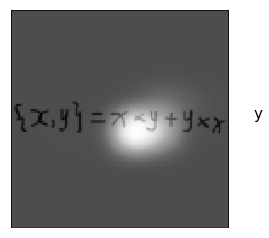

tensor([5.5606e-07, 1.6839e-06, 1.2077e-06, 5.2955e-07, 7.3943e-07, 1.0402e-06,
        7.0905e-07, 2.4894e-07, 1.0791e-07, 8.5749e-09, 3.0879e-08, 5.6359e-08,
        1.0828e-07, 2.6363e-07, 6.8698e-08, 3.3216e-08, 1.2121e-07, 2.3668e-07,
        7.9922e-07, 2.7807e-06, 3.5293e-06, 5.4474e-05, 4.4896e-05, 1.3999e-06,
        1.7406e-06, 1.6497e-04, 1.6653e-03, 3.9559e-04, 1.2541e-02, 1.2264e-01,
        4.8433e-02, 4.0536e-05, 1.0469e-06, 3.9590e-03, 5.5833e-03, 9.4230e-03,
        4.8858e-01, 2.9708e-01, 8.5599e-03, 2.2464e-04, 3.2671e-08, 5.0772e-06,
        4.3391e-06, 4.9390e-06, 7.4494e-05, 2.0864e-04, 8.6760e-05, 1.3046e-06,
        1.2299e-06, 4.5675e-06, 1.1230e-05, 3.4215e-05, 5.5709e-05, 2.1661e-05,
        9.2714e-06, 3.4993e-07, 1.8501e-06, 1.5343e-05, 1.6903e-05, 1.8506e-05,
        1.0941e-05, 8.6996e-06, 3.5288e-06, 5.5820e-07])


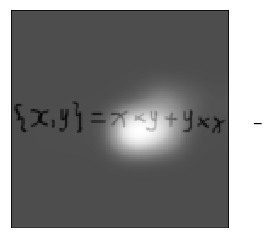

tensor([1.7096e-07, 5.0315e-07, 4.0369e-07, 2.0677e-07, 2.4028e-07, 3.4998e-07,
        2.9757e-07, 8.9632e-08, 2.7574e-08, 2.6408e-09, 7.8509e-09, 1.3616e-08,
        2.1530e-08, 5.8564e-08, 2.0437e-08, 1.0372e-08, 2.5517e-08, 4.4230e-08,
        1.0640e-07, 2.8243e-07, 3.7855e-07, 7.6200e-06, 1.3164e-05, 5.0227e-07,
        5.4936e-07, 3.0112e-05, 1.0855e-04, 1.1515e-05, 4.2752e-04, 5.4452e-03,
        5.9760e-03, 1.6230e-05, 2.3655e-07, 6.2350e-04, 1.6006e-03, 2.0359e-03,
        2.0528e-01, 7.4777e-01, 2.9691e-02, 6.6607e-04, 6.9115e-09, 6.3588e-07,
        4.8934e-07, 6.0088e-07, 1.9039e-05, 1.0763e-04, 7.6444e-05, 1.2044e-06,
        2.6721e-07, 7.7853e-07, 2.2606e-06, 7.8370e-06, 1.5649e-05, 1.0117e-05,
        6.3513e-06, 1.8246e-07, 7.0108e-07, 6.2251e-06, 8.6639e-06, 1.0861e-05,
        6.7319e-06, 6.3018e-06, 3.4407e-06, 3.9176e-07])


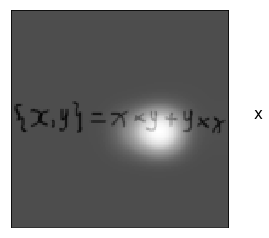

tensor([2.2164e-07, 4.9101e-07, 4.0254e-07, 2.0824e-07, 2.4886e-07, 3.1196e-07,
        2.2984e-07, 8.6511e-08, 5.1132e-08, 5.1765e-09, 1.4885e-08, 2.2350e-08,
        3.1892e-08, 7.5227e-08, 2.7996e-08, 1.4506e-08, 3.7775e-08, 8.4070e-08,
        2.1437e-07, 4.9842e-07, 5.2585e-07, 8.8996e-06, 1.6151e-05, 7.6905e-07,
        6.8512e-07, 6.6228e-05, 2.0007e-04, 1.7635e-05, 9.6765e-04, 2.7597e-02,
        2.0035e-02, 4.3211e-05, 1.9901e-07, 9.1656e-04, 1.1949e-03, 1.4326e-03,
        2.6390e-01, 6.4286e-01, 3.8819e-02, 1.1733e-03, 7.5552e-09, 8.6172e-07,
        6.3573e-07, 8.2141e-07, 5.0138e-05, 4.1575e-04, 1.7850e-04, 3.1991e-06,
        3.8274e-07, 1.4226e-06, 2.5898e-06, 9.5930e-06, 2.2432e-05, 1.5547e-05,
        8.7967e-06, 3.1298e-07, 6.9097e-07, 4.9023e-06, 5.1942e-06, 7.8011e-06,
        5.9968e-06, 5.8305e-06, 3.2157e-06, 4.6978e-07])


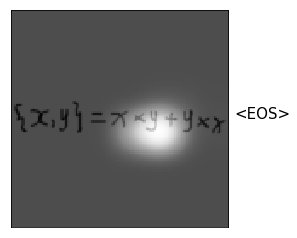

tensor([1.1474e-06, 2.0335e-06, 1.7507e-06, 8.8744e-07, 1.0076e-06, 1.4226e-06,
        1.0222e-06, 3.5042e-07, 1.5233e-07, 1.3853e-08, 3.9635e-08, 5.8361e-08,
        9.0203e-08, 2.5560e-07, 9.4013e-08, 4.4968e-08, 8.8302e-08, 1.3324e-07,
        4.7943e-07, 1.2493e-06, 1.1659e-06, 1.8400e-05, 4.9657e-05, 2.9531e-06,
        5.0017e-07, 2.6866e-05, 1.0043e-04, 1.1428e-05, 4.7141e-04, 1.5928e-02,
        2.5794e-02, 1.3515e-04, 1.3935e-07, 2.7883e-04, 4.2736e-04, 7.4826e-04,
        8.8914e-02, 7.1951e-01, 1.4101e-01, 3.3394e-03, 1.3526e-08, 8.4107e-07,
        5.8176e-07, 8.9490e-07, 5.5678e-05, 1.4137e-03, 1.1983e-03, 1.9711e-05,
        1.2988e-06, 4.3834e-06, 9.0951e-06, 3.3541e-05, 9.1806e-05, 1.1695e-04,
        7.7661e-05, 2.4642e-06, 3.7117e-06, 2.4893e-05, 2.7928e-05, 3.8591e-05,
        3.4272e-05, 3.9262e-05, 2.0581e-05, 3.0750e-06])


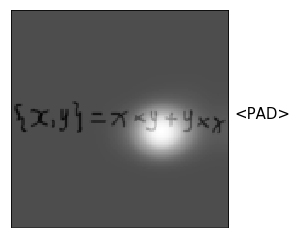

In [13]:
show_attention_images(img, preds_batch, attn_low, enc_low_res.size(2), enc_low_res.size(3), smooth=True)

## High resolution attention

In [14]:
attn_high

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

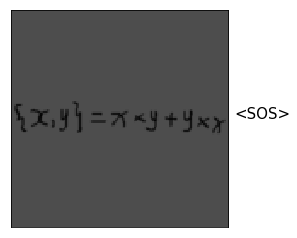

tensor([1.6260e-06, 6.9404e-06, 5.2708e-06, 6.4332e-06, 6.1256e-06, 4.6756e-06,
        3.7665e-06, 3.6107e-06, 3.6025e-06, 3.5803e-06, 3.6441e-06, 3.3686e-06,
        3.0951e-06, 2.2399e-06, 1.2180e-06, 2.4425e-06, 2.4850e-06, 9.3155e-06,
        8.5654e-06, 1.4669e-05, 9.2972e-06, 6.1563e-06, 4.4542e-06, 4.1024e-06,
        3.9772e-06, 3.5879e-06, 3.0793e-06, 2.6709e-06, 2.4097e-06, 1.3662e-06,
        7.8457e-07, 1.1715e-05, 2.0941e-06, 1.1800e-06, 3.1442e-07, 3.0972e-07,
        2.6218e-07, 3.2096e-07, 3.6990e-07, 4.2423e-07, 4.1939e-07, 3.3480e-07,
        2.5135e-07, 2.7677e-07, 3.2910e-07, 2.8459e-07, 2.8423e-07, 4.0779e-06,
        9.4614e-07, 4.3368e-07, 9.3669e-08, 9.4158e-08, 9.1949e-08, 1.4064e-07,
        1.9331e-07, 2.4981e-07, 2.2475e-07, 1.7359e-07, 1.4491e-07, 2.0236e-07,
        6.2452e-07, 5.7643e-07, 4.5491e-07, 6.3186e-06, 5.4847e-07, 3.3052e-07,
        5.2693e-08, 6.1948e-08, 1.3006e-07, 2.0163e-07, 2.4322e-07, 1.9339e-07,
        1.3178e-07, 1.2944e-07, 1.6227e-

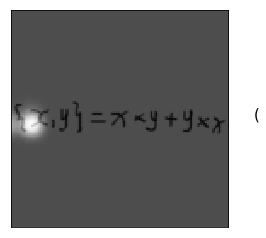

tensor([1.1601e-07, 1.6234e-07, 1.4905e-07, 2.0174e-07, 2.3858e-07, 2.3826e-07,
        2.2826e-07, 2.3242e-07, 2.3673e-07, 2.3864e-07, 2.4471e-07, 2.3695e-07,
        2.3879e-07, 2.0535e-07, 1.5482e-07, 5.3308e-07, 1.8163e-07, 4.8551e-07,
        7.6924e-07, 1.3390e-06, 1.1699e-06, 1.0325e-06, 9.2598e-07, 9.4163e-07,
        9.3889e-07, 8.3808e-07, 6.9529e-07, 6.2682e-07, 4.6242e-07, 2.7414e-07,
        1.4625e-07, 1.1680e-06, 3.5647e-07, 1.2926e-07, 1.1962e-08, 1.1623e-08,
        1.0419e-08, 1.4847e-08, 2.1705e-08, 2.7250e-08, 2.7497e-08, 2.1427e-08,
        1.5799e-08, 1.9147e-08, 2.1338e-08, 1.6065e-08, 1.4180e-08, 1.8197e-07,
        1.1735e-07, 3.6317e-08, 2.7400e-09, 3.2994e-09, 3.7420e-09, 6.6310e-09,
        1.0899e-08, 1.5185e-08, 1.3300e-08, 9.4553e-09, 8.0686e-09, 1.4025e-08,
        4.3325e-08, 3.8586e-08, 2.7399e-08, 3.3445e-07, 4.2027e-08, 2.0149e-08,
        1.5733e-09, 2.1746e-09, 7.1443e-09, 1.6821e-08, 2.7603e-08, 2.1199e-08,
        9.6832e-09, 8.8902e-09, 1.2112e-

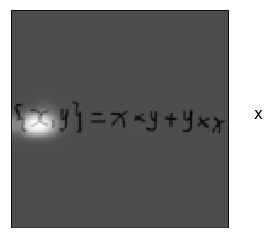

tensor([3.5109e-07, 2.0636e-07, 2.6095e-07, 3.9781e-07, 5.8061e-07, 7.4370e-07,
        8.1370e-07, 8.5589e-07, 8.9141e-07, 9.2251e-07, 9.6349e-07, 1.0172e-06,
        1.2377e-06, 1.2139e-06, 1.1836e-06, 6.1192e-06, 9.5342e-07, 1.5831e-06,
        2.2820e-06, 4.7596e-06, 5.3413e-06, 5.9604e-06, 6.0697e-06, 6.3069e-06,
        6.5059e-06, 6.2203e-06, 5.5874e-06, 5.6508e-06, 4.5038e-06, 2.6804e-06,
        1.7350e-06, 1.2426e-05, 2.2327e-06, 9.4763e-07, 6.7354e-08, 6.0777e-08,
        5.6907e-08, 9.0734e-08, 1.5332e-07, 2.0266e-07, 2.1830e-07, 1.8014e-07,
        1.4190e-07, 1.9102e-07, 2.2997e-07, 1.6551e-07, 1.4516e-07, 1.6656e-06,
        7.5502e-07, 3.2745e-07, 1.4578e-08, 1.6763e-08, 2.1769e-08, 4.3116e-08,
        7.7063e-08, 1.1396e-07, 1.0445e-07, 7.7738e-08, 7.1771e-08, 1.4762e-07,
        4.8998e-07, 4.4151e-07, 2.7599e-07, 2.6082e-06, 2.4749e-07, 1.4440e-07,
        6.8495e-09, 9.2622e-09, 3.5073e-08, 1.1828e-07, 2.4077e-07, 1.9522e-07,
        7.8422e-08, 7.6392e-08, 1.1794e-

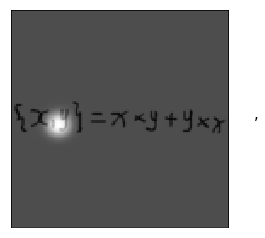

tensor([4.3386e-08, 5.4572e-08, 4.8223e-08, 6.5449e-08, 8.9258e-08, 1.0707e-07,
        1.1546e-07, 1.2087e-07, 1.2498e-07, 1.2742e-07, 1.3146e-07, 1.3342e-07,
        1.5069e-07, 1.2839e-07, 9.9480e-08, 1.3360e-06, 1.0828e-07, 2.0590e-07,
        1.9727e-07, 4.9444e-07, 4.9112e-07, 5.5383e-07, 6.0223e-07, 6.6737e-07,
        6.9846e-07, 6.3800e-07, 5.3093e-07, 5.1265e-07, 3.6358e-07, 1.9642e-07,
        1.2586e-07, 1.2254e-06, 2.2680e-07, 4.7527e-08, 2.4338e-09, 2.2127e-09,
        2.1920e-09, 3.9831e-09, 7.6092e-09, 1.1042e-08, 1.1920e-08, 8.9270e-09,
        6.3705e-09, 8.5488e-09, 9.6614e-09, 6.5131e-09, 6.3413e-09, 8.4469e-08,
        5.9702e-08, 1.3274e-08, 4.1912e-10, 5.0471e-10, 7.0319e-10, 1.7769e-09,
        3.7913e-09, 6.2864e-09, 5.3184e-09, 3.3963e-09, 2.9455e-09, 6.5063e-09,
        2.7345e-08, 2.6085e-08, 1.5917e-08, 2.0679e-07, 1.5702e-08, 6.5403e-09,
        2.1363e-10, 3.0166e-10, 1.3486e-09, 5.6331e-09, 1.3156e-08, 9.5076e-09,
        3.0680e-09, 2.6158e-09, 4.4682e-

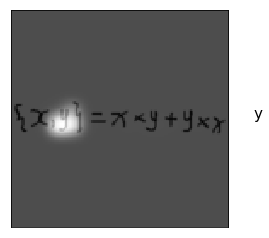

tensor([6.8444e-07, 4.0003e-07, 4.4309e-07, 6.0015e-07, 8.7718e-07, 1.1549e-06,
        1.3043e-06, 1.3770e-06, 1.4313e-06, 1.4626e-06, 1.4964e-06, 1.5741e-06,
        2.0105e-06, 2.0206e-06, 2.0586e-06, 1.8032e-05, 1.8321e-06, 2.6975e-06,
        3.5783e-06, 7.8360e-06, 9.1089e-06, 1.0161e-05, 1.0477e-05, 1.0979e-05,
        1.1424e-05, 1.0959e-05, 9.7858e-06, 1.0131e-05, 8.2617e-06, 5.5370e-06,
        3.7166e-06, 2.2752e-05, 3.0159e-06, 9.7230e-07, 7.3160e-08, 6.9968e-08,
        6.9330e-08, 1.1336e-07, 1.9263e-07, 2.5511e-07, 2.7453e-07, 2.2238e-07,
        1.6995e-07, 2.3322e-07, 2.9281e-07, 2.5227e-07, 2.1540e-07, 2.4750e-06,
        8.8563e-07, 3.0434e-07, 1.4066e-08, 1.6755e-08, 2.3464e-08, 5.0641e-08,
        9.5354e-08, 1.4340e-07, 1.2475e-07, 8.6679e-08, 7.7420e-08, 1.6362e-07,
        6.4003e-07, 7.5347e-07, 4.2182e-07, 4.8774e-06, 3.0185e-07, 1.6960e-07,
        7.4170e-09, 1.1416e-08, 4.9933e-08, 1.7351e-07, 3.4755e-07, 2.4733e-07,
        9.1948e-08, 8.4605e-08, 1.3029e-

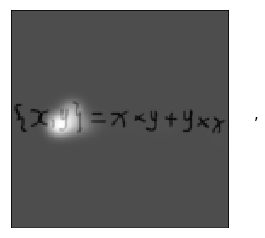

tensor([1.4931e-07, 1.5955e-07, 1.3891e-07, 1.9505e-07, 2.8584e-07, 3.6263e-07,
        4.0434e-07, 4.2956e-07, 4.4595e-07, 4.5254e-07, 4.6332e-07, 4.6653e-07,
        5.1905e-07, 4.3965e-07, 3.6470e-07, 4.1235e-06, 3.1006e-07, 5.9482e-07,
        6.5651e-07, 1.7398e-06, 1.7413e-06, 1.9239e-06, 2.0479e-06, 2.2382e-06,
        2.3186e-06, 2.0823e-06, 1.6849e-06, 1.5965e-06, 1.1006e-06, 5.7970e-07,
        4.0828e-07, 2.8639e-06, 5.4162e-07, 1.0214e-07, 5.3678e-09, 4.6831e-09,
        4.6166e-09, 8.6552e-09, 1.7150e-08, 2.5559e-08, 2.7815e-08, 2.0222e-08,
        1.3643e-08, 1.7854e-08, 2.0372e-08, 1.4823e-08, 1.5745e-08, 1.8506e-07,
        1.2602e-07, 2.7148e-08, 8.7753e-10, 1.0204e-09, 1.4626e-09, 3.9721e-09,
        8.9287e-09, 1.5337e-08, 1.2664e-08, 7.6108e-09, 6.1632e-09, 1.3407e-08,
        6.5333e-08, 6.9801e-08, 4.5700e-08, 5.5161e-07, 3.3043e-08, 1.4089e-08,
        4.4622e-10, 6.2333e-10, 3.9036e-09, 1.6836e-08, 4.1133e-08, 2.6898e-08,
        7.1641e-09, 5.8727e-09, 1.0038e-

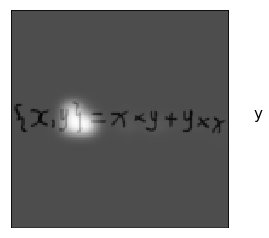

tensor([1.5791e-06, 7.7734e-07, 8.4019e-07, 1.1178e-06, 1.8251e-06, 2.6493e-06,
        3.1816e-06, 3.4565e-06, 3.6520e-06, 3.7744e-06, 3.8923e-06, 4.1362e-06,
        5.4183e-06, 5.6975e-06, 5.9693e-06, 5.5058e-05, 3.0672e-06, 5.2789e-06,
        7.3838e-06, 1.8009e-05, 2.2488e-05, 2.7269e-05, 2.8750e-05, 3.0402e-05,
        3.1639e-05, 2.9884e-05, 2.5631e-05, 2.5621e-05, 2.0099e-05, 1.4162e-05,
        9.5118e-06, 5.9097e-05, 5.9685e-06, 1.6507e-06, 9.7015e-08, 9.4514e-08,
        9.7186e-08, 1.7588e-07, 3.2319e-07, 4.4516e-07, 4.8550e-07, 3.8730e-07,
        2.8767e-07, 3.8984e-07, 4.8364e-07, 4.4603e-07, 4.0930e-07, 6.9544e-06,
        1.7355e-06, 5.5235e-07, 1.9810e-08, 2.3511e-08, 3.4065e-08, 8.2553e-08,
        1.6853e-07, 2.6601e-07, 2.2462e-07, 1.4497e-07, 1.2519e-07, 2.6936e-07,
        1.1612e-06, 1.5406e-06, 9.2103e-07, 1.7267e-05, 5.2012e-07, 2.9769e-07,
        1.1457e-08, 1.6012e-08, 8.2112e-08, 3.3804e-07, 8.4005e-07, 5.9184e-07,
        1.6453e-07, 1.4099e-07, 2.2630e-

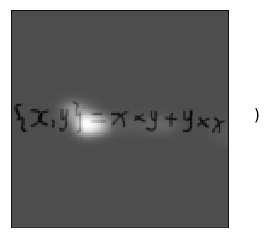

tensor([4.3133e-06, 2.4652e-06, 3.3440e-06, 5.3238e-06, 8.6898e-06, 1.1974e-05,
        1.3933e-05, 1.5287e-05, 1.6195e-05, 1.6610e-05, 1.6987e-05, 1.6850e-05,
        1.9106e-05, 1.6766e-05, 1.7339e-05, 7.3394e-05, 7.2690e-06, 1.5271e-05,
        2.3424e-05, 5.8038e-05, 6.2533e-05, 7.4063e-05, 7.9092e-05, 8.6616e-05,
        9.0083e-05, 8.2479e-05, 6.7643e-05, 6.1200e-05, 4.2743e-05, 2.5649e-05,
        2.1708e-05, 7.2417e-05, 1.4756e-05, 4.4995e-06, 2.0854e-07, 1.6512e-07,
        1.5511e-07, 3.0007e-07, 6.2177e-07, 9.5084e-07, 1.0779e-06, 8.3887e-07,
        6.1221e-07, 8.4620e-07, 1.0084e-06, 8.0721e-07, 8.4855e-07, 8.0681e-06,
        3.9668e-06, 1.2695e-06, 3.7623e-08, 4.0432e-08, 5.6248e-08, 1.4235e-07,
        3.1946e-07, 5.4395e-07, 4.5708e-07, 2.8213e-07, 2.3096e-07, 4.7918e-07,
        2.1945e-06, 2.5499e-06, 1.8239e-06, 2.2948e-05, 1.1559e-06, 5.9403e-07,
        2.0719e-08, 2.5013e-08, 1.3592e-07, 6.0008e-07, 1.6380e-06, 1.2955e-06,
        3.3944e-07, 2.8021e-07, 4.3206e-

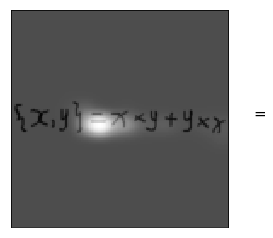

tensor([8.7182e-08, 1.0893e-07, 8.5177e-08, 1.2699e-07, 1.6598e-07, 1.8871e-07,
        2.0788e-07, 2.2525e-07, 2.3573e-07, 2.3739e-07, 2.4051e-07, 2.3744e-07,
        2.4153e-07, 2.0429e-07, 1.4023e-07, 1.4225e-06, 2.0182e-07, 3.0206e-07,
        2.7744e-07, 6.5451e-07, 5.0650e-07, 5.0271e-07, 5.5079e-07, 6.1879e-07,
        6.4713e-07, 5.8320e-07, 4.8069e-07, 4.6127e-07, 3.3996e-07, 1.6479e-07,
        9.2763e-08, 1.3350e-06, 2.6680e-07, 5.8941e-08, 4.5285e-09, 3.7205e-09,
        3.1449e-09, 5.0854e-09, 9.2914e-09, 1.3951e-08, 1.5484e-08, 1.1521e-08,
        7.7891e-09, 9.8890e-09, 1.0912e-08, 7.6694e-09, 6.1203e-09, 1.2726e-07,
        6.2974e-08, 1.6249e-08, 8.1147e-10, 8.4381e-10, 1.0829e-09, 2.6153e-09,
        5.4690e-09, 9.5254e-09, 8.8888e-09, 5.8095e-09, 4.7946e-09, 1.0722e-08,
        4.7503e-08, 4.3043e-08, 1.8356e-08, 3.6071e-07, 2.4070e-08, 1.0475e-08,
        4.7947e-10, 5.8266e-10, 4.0212e-09, 1.4799e-08, 2.8910e-08, 2.0300e-08,
        6.2912e-09, 5.5313e-09, 9.2758e-

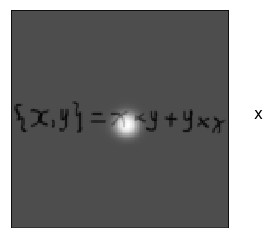

tensor([6.6730e-06, 3.3855e-06, 2.7464e-06, 3.4953e-06, 5.1217e-06, 6.6491e-06,
        7.5063e-06, 7.9544e-06, 8.2372e-06, 8.3407e-06, 8.4270e-06, 8.5346e-06,
        1.0023e-05, 9.6355e-06, 8.9115e-06, 6.1710e-05, 1.3243e-05, 1.6180e-05,
        1.6840e-05, 3.9894e-05, 3.6468e-05, 3.6709e-05, 3.5900e-05, 3.6620e-05,
        3.7014e-05, 3.3737e-05, 2.8245e-05, 2.7615e-05, 2.1849e-05, 1.2771e-05,
        9.2744e-06, 8.9792e-05, 2.1321e-05, 4.6555e-06, 2.2846e-07, 2.0303e-07,
        1.8497e-07, 3.2719e-07, 5.9796e-07, 8.3336e-07, 9.0137e-07, 6.7966e-07,
        4.6786e-07, 5.9306e-07, 7.4299e-07, 5.6086e-07, 6.0716e-07, 1.1229e-05,
        5.3730e-06, 1.1788e-06, 4.2272e-08, 4.7135e-08, 6.1173e-08, 1.4957e-07,
        3.0262e-07, 5.0524e-07, 4.5396e-07, 2.9525e-07, 2.4546e-07, 5.5662e-07,
        2.8108e-06, 2.9356e-06, 1.6066e-06, 2.7144e-05, 1.5310e-06, 6.0951e-07,
        2.3007e-08, 3.0519e-08, 1.9030e-07, 7.5535e-07, 1.7475e-06, 1.1913e-06,
        3.2261e-07, 2.6757e-07, 4.5412e-

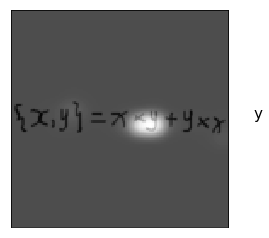

tensor([9.0750e-06, 3.6267e-06, 3.3205e-06, 4.6038e-06, 7.6433e-06, 1.0961e-05,
        1.3320e-05, 1.4688e-05, 1.5648e-05, 1.6279e-05, 1.6935e-05, 1.8041e-05,
        2.2711e-05, 2.3260e-05, 2.5577e-05, 1.8080e-04, 1.4256e-05, 1.9914e-05,
        2.7166e-05, 6.9515e-05, 7.5124e-05, 8.5493e-05, 9.0525e-05, 9.6921e-05,
        1.0107e-04, 9.4453e-05, 7.9961e-05, 7.8302e-05, 5.9918e-05, 3.6540e-05,
        3.0438e-05, 2.1630e-04, 2.4140e-05, 5.3515e-06, 3.0581e-07, 3.0954e-07,
        2.9179e-07, 5.2612e-07, 9.9996e-07, 1.4260e-06, 1.6013e-06, 1.2884e-06,
        9.4109e-07, 1.2710e-06, 1.5988e-06, 1.3346e-06, 1.4446e-06, 2.6910e-05,
        7.1504e-06, 1.8361e-06, 6.8974e-08, 7.9163e-08, 1.0583e-07, 2.5304e-07,
        5.1819e-07, 8.7298e-07, 7.8829e-07, 5.2085e-07, 4.4818e-07, 1.0373e-06,
        5.1935e-06, 6.2291e-06, 3.5527e-06, 7.0328e-05, 2.2303e-06, 9.8944e-07,
        3.8998e-08, 5.0628e-08, 2.6061e-07, 1.0695e-06, 2.7199e-06, 2.1774e-06,
        6.1680e-07, 5.1752e-07, 8.6722e-

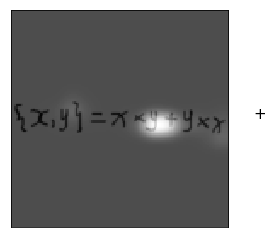

tensor([3.2505e-07, 3.4463e-07, 3.0865e-07, 4.5808e-07, 6.1935e-07, 7.6330e-07,
        8.9404e-07, 9.9686e-07, 1.0595e-06, 1.0833e-06, 1.1094e-06, 1.0793e-06,
        1.0633e-06, 7.4227e-07, 4.6794e-07, 3.3326e-06, 5.3528e-07, 8.2269e-07,
        8.0085e-07, 1.9995e-06, 1.5283e-06, 1.5494e-06, 1.7210e-06, 1.9695e-06,
        2.0620e-06, 1.8500e-06, 1.5175e-06, 1.4345e-06, 1.0773e-06, 4.8183e-07,
        3.1380e-07, 1.9820e-06, 6.3378e-07, 1.4810e-07, 1.1337e-08, 8.2257e-09,
        7.4973e-09, 1.2822e-08, 2.4110e-08, 3.6221e-08, 3.9843e-08, 2.9815e-08,
        2.1016e-08, 2.6599e-08, 3.1017e-08, 2.1871e-08, 2.1835e-08, 2.6660e-07,
        1.7184e-07, 4.3803e-08, 2.3010e-09, 2.1962e-09, 2.8736e-09, 7.0604e-09,
        1.5415e-08, 2.6427e-08, 2.3074e-08, 1.4442e-08, 1.1875e-08, 2.6328e-08,
        1.3544e-07, 1.2141e-07, 6.6549e-08, 8.1530e-07, 5.6172e-08, 2.3029e-08,
        1.2901e-09, 1.4118e-09, 9.4191e-09, 3.3648e-08, 7.0889e-08, 4.8627e-08,
        1.4365e-08, 1.1888e-08, 2.1118e-

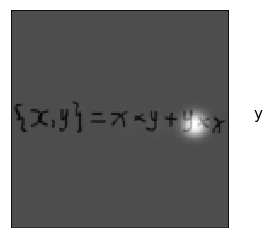

tensor([1.0666e-05, 5.8702e-06, 6.6664e-06, 8.9650e-06, 1.4294e-05, 2.0234e-05,
        2.4206e-05, 2.6601e-05, 2.8348e-05, 2.9526e-05, 3.0742e-05, 3.2231e-05,
        3.9707e-05, 3.7969e-05, 3.5255e-05, 2.1971e-04, 1.8249e-05, 3.5274e-05,
        4.6411e-05, 1.1414e-04, 1.2698e-04, 1.4814e-04, 1.5686e-04, 1.6835e-04,
        1.7541e-04, 1.6349e-04, 1.3677e-04, 1.3204e-04, 9.9995e-05, 6.1513e-05,
        4.1602e-05, 2.9858e-04, 3.6860e-05, 1.1238e-05, 4.9248e-07, 4.3083e-07,
        4.2072e-07, 7.7760e-07, 1.5077e-06, 2.1535e-06, 2.4042e-06, 1.9317e-06,
        1.4424e-06, 1.9669e-06, 2.3780e-06, 1.9868e-06, 2.0319e-06, 4.9151e-05,
        1.1651e-05, 4.0107e-06, 1.0578e-07, 1.1873e-07, 1.6740e-07, 4.1168e-07,
        8.5750e-07, 1.4162e-06, 1.2374e-06, 8.0469e-07, 7.1327e-07, 1.6187e-06,
        7.1702e-06, 8.3000e-06, 5.0397e-06, 1.2638e-04, 3.3132e-06, 1.9061e-06,
        5.9093e-08, 7.1821e-08, 3.8498e-07, 1.6871e-06, 4.4359e-06, 3.3794e-06,
        8.9193e-07, 7.5687e-07, 1.3332e-

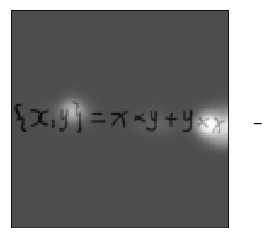

tensor([6.2819e-06, 3.3247e-06, 3.0704e-06, 4.6883e-06, 7.6591e-06, 1.0840e-05,
        1.2509e-05, 1.3355e-05, 1.4072e-05, 1.4895e-05, 1.6040e-05, 1.7184e-05,
        2.0543e-05, 1.7760e-05, 1.4407e-05, 1.5880e-04, 1.1876e-05, 1.7402e-05,
        2.0253e-05, 5.5497e-05, 6.2614e-05, 7.2506e-05, 7.3621e-05, 7.5985e-05,
        7.8112e-05, 7.3364e-05, 6.2002e-05, 5.8189e-05, 4.5251e-05, 2.6140e-05,
        1.3750e-05, 1.5029e-04, 3.6692e-05, 7.3382e-06, 3.9664e-07, 4.0886e-07,
        3.8448e-07, 6.6852e-07, 1.2841e-06, 1.8610e-06, 2.1191e-06, 1.7126e-06,
        1.2710e-06, 1.7170e-06, 1.9785e-06, 1.6652e-06, 1.2034e-06, 1.6972e-05,
        1.0400e-05, 2.8955e-06, 8.6383e-08, 1.0881e-07, 1.3477e-07, 2.7680e-07,
        5.4442e-07, 9.1373e-07, 8.3736e-07, 5.7363e-07, 5.2245e-07, 1.1343e-06,
        5.0435e-06, 6.0046e-06, 2.5673e-06, 3.3395e-05, 2.6757e-06, 1.1732e-06,
        4.5404e-08, 5.3398e-08, 2.1992e-07, 8.2508e-07, 2.2772e-06, 2.1098e-06,
        5.6481e-07, 4.9401e-07, 8.7159e-

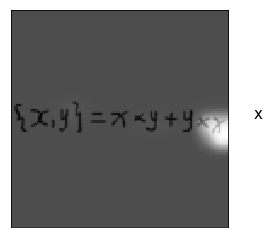

tensor([1.2200e-05, 3.1877e-06, 3.5169e-06, 5.3429e-06, 8.9515e-06, 1.3537e-05,
        1.6515e-05, 1.8144e-05, 1.9373e-05, 2.0502e-05, 2.1828e-05, 2.4126e-05,
        3.2275e-05, 3.3442e-05, 3.6066e-05, 2.4763e-04, 2.1953e-05, 2.5714e-05,
        3.6115e-05, 9.3125e-05, 1.1532e-04, 1.3931e-04, 1.4562e-04, 1.5373e-04,
        1.6105e-04, 1.5715e-04, 1.4173e-04, 1.4240e-04, 1.1981e-04, 8.1757e-05,
        4.9702e-05, 4.2272e-04, 3.8171e-05, 1.1868e-05, 9.2948e-07, 1.0495e-06,
        1.1025e-06, 1.8224e-06, 3.1528e-06, 4.2259e-06, 4.7131e-06, 3.9811e-06,
        3.1066e-06, 4.2135e-06, 5.4881e-06, 5.0393e-06, 4.1267e-06, 7.0999e-05,
        1.1916e-05, 5.0642e-06, 2.2137e-07, 2.7704e-07, 3.7852e-07, 7.6662e-07,
        1.4430e-06, 2.2269e-06, 1.9819e-06, 1.3935e-06, 1.2678e-06, 2.8291e-06,
        1.2308e-05, 1.6001e-05, 8.4056e-06, 1.4065e-04, 4.3454e-06, 2.7543e-06,
        1.3229e-07, 1.6270e-07, 7.5671e-07, 2.7695e-06, 6.5033e-06, 5.1774e-06,
        1.4872e-06, 1.2850e-06, 2.1656e-

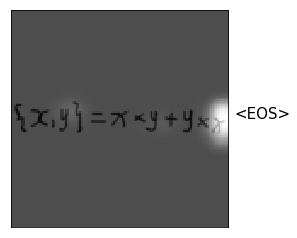

tensor([2.5156e-05, 8.3668e-06, 7.9232e-06, 1.2417e-05, 2.2363e-05, 3.4840e-05,
        4.4503e-05, 5.0505e-05, 5.4898e-05, 5.8517e-05, 6.2862e-05, 6.9784e-05,
        8.6618e-05, 8.2011e-05, 8.4879e-05, 8.5887e-04, 3.8110e-05, 3.8688e-05,
        5.9613e-05, 1.6513e-04, 2.0521e-04, 2.8028e-04, 3.2741e-04, 3.6976e-04,
        3.9739e-04, 3.8354e-04, 3.3922e-04, 3.4851e-04, 2.7401e-04, 1.8107e-04,
        1.4475e-04, 1.5189e-03, 1.0992e-04, 1.8457e-05, 8.1503e-07, 8.3342e-07,
        8.4800e-07, 1.6199e-06, 3.2743e-06, 4.8647e-06, 5.6709e-06, 4.7034e-06,
        3.6804e-06, 5.4346e-06, 6.6034e-06, 6.2909e-06, 6.2600e-06, 2.7641e-04,
        4.2062e-05, 1.1100e-05, 2.5220e-07, 3.1097e-07, 4.8084e-07, 1.2166e-06,
        2.7275e-06, 4.7178e-06, 4.1293e-06, 2.6053e-06, 2.4226e-06, 6.0283e-06,
        2.8110e-05, 3.5462e-05, 1.7665e-05, 7.4081e-04, 1.2332e-05, 4.9916e-06,
        1.6509e-07, 1.9260e-07, 1.0243e-06, 5.3591e-06, 1.5122e-05, 1.2880e-05,
        3.1980e-06, 2.6628e-06, 5.0575e-

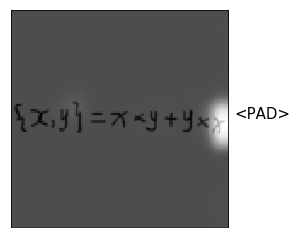

In [15]:
show_attention_images(img, preds_batch, attn_high, enc_high_res.size(2), enc_high_res.size(3), smooth=True)